In [1]:
# Specify visible cuda device
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array

/home/chawins/.conda/envs/tsa3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load and process data... can skip this

In [3]:
def load_images(data_dir):
    
    df = pd.read_csv(data_dir + 'camera.csv')
    df = df[df['frame_id'] == 'center_camera']
    df = df.sort_values('timestamp')
    x = np.zeros((len(df), 66, 200, 3))
    for i, fname in enumerate(df['filename']):
        x[i] = load_img(data_dir + fname, target_size=(66, 200), 
                        interpolation='nearest')
    x = (x / 255).astype(np.float32)
    stamps = np.array(df['timestamp'], dtype=np.float128)
    return x, stamps


def load_steering(data_dir):
    
    df = pd.read_csv(data_dir + 'steering.csv')
    df = df.sort_values('timestamp')
    angles = np.array(df['angle'], dtype=np.float32)
    stamps = np.array(df['timestamp'], dtype=np.float128)
    return angles, stamps


def match_angles(x, angles, stamps_im, stamps_an):
    
    # Trim camera timestamp to lie in range of steering timestamp
    min_ind = np.searchsorted(stamps_im, np.min(stamps_an))
    max_ind = np.searchsorted(stamps_im, np.max(stamps_an))
    stamps_trim = stamps_im[min_ind:max_ind]
    x_trim = x[min_ind:max_ind]
    
    # Interpolate corresponding angle for each image
    indices = np.searchsorted(stamps_an, stamps_trim)
    y = np.zeros((len(stamps_trim), 1))
    for i, ind in enumerate(indices):
        y[i] = (angles[ind - 1] + (angles[ind] - angles[ind - 1]) 
                / (stamps_an[ind] - stamps_an[ind - 1]) 
                * (stamps_trim[i] - stamps_an[ind - 1]))
    return x_trim, y


def load_dataset_udacity(main_dir):
    
    # Load train set
    data_dir = main_dir + '/train/'
    angles, stamps_an = load_steering(data_dir)
    x_train, stamps_im = load_images(data_dir)
    x_train, y_train = match_angles(x_train, angles, stamps_im, stamps_an)
    
    # Load test set
    data_dir = main_dir + '/test/'
    angles, stamps_an = load_steering(data_dir)
    x_test, stamps_im = load_images(data_dir)
    x_test, y_test = match_angles(x_test, angles, stamps_im, stamps_an)
    
    return x_train, y_train, x_test, y_test


# x_train, y_train, x_test, y_test = load_dataset_udacity('/data/scsi/DART/data/lane_follow/')
# pickle.dump([x_train, y_train, x_test, y_test], open('uda_ch2_processed.p', 'wb'), protocol=4)  

### Start here

In [4]:
x_train, y_train, x_test, y_test = pickle.load(open('/data/scsi/DART/data/uda_ch2_processed.p', 'rb'))

In [ ]:
# convert to yuv if needed

from skimage.color import rgb2yuv

x_train = rgb2yuv(x_train)
x_test = rgb2yuv(x_test)

In [6]:
from keras.models import Sequential
from keras.layers import Lambda, Conv2D, Flatten, Dense
from keras.optimizers import Adam

def build_dave(mean, std): 

    def norm_input(x): return (x - mean) / std
        
    model = Sequential()

    # model.add(Lambda(norm_input, input_shape=(66, 200, 3)))
    
    model.add(Conv2D(24, (5, 5), activation='relu', strides=(2, 2), 
                     input_shape=(66, 200, 3)))
    model.add(Conv2D(36, (5, 5), activation='relu', strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation='relu', strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(1164, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse',
                  optimizer=Adam(lr=0.0001))
    return model

### Traing model  
Can go to load pre-trained weight below

In [202]:
from keras.callbacks import ModelCheckpoint

batch_size = 64
n_epoch = 25
filepath = './keras_weights/dave_rgb.best.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', 
                             verbose=1, save_best_only=True)
callbacks_list = [checkpoint]


model = build_dave(0, 0)
model.fit(x_train, y_train,
          batch_size=batch_size, epochs=n_epoch, 
          validation_data=(x_test, y_test), 
          callbacks=callbacks_list)
# model.fit(x, y,
#           batch_size=batch_size, epochs=n_epoch, 
#           validation_split=0.2, 
#           callbacks=callbacks_list)

Train on 33808 samples, validate on 5279 samples
Epoch 1/25
33808/33808 [==============================] - 13s 372us/step - loss: 0.0454 - val_loss: 0.0307

Epoch 00001: val_loss improved from inf to 0.03067, saving model to ./keras_weights/dave_rgb.best.h5
Epoch 2/25
33808/33808 [==============================] - 12s 367us/step - loss: 0.0222 - val_loss: 0.0379

Epoch 00002: val_loss did not improve
Epoch 3/25
33808/33808 [==============================] - 12s 364us/step - loss: 0.0124 - val_loss: 0.0491

Epoch 00003: val_loss did not improve
Epoch 4/25
33808/33808 [==============================] - 12s 354us/step - loss: 0.0080 - val_loss: 0.0326

Epoch 00004: val_loss did not improve
Epoch 5/25
33808/33808 [==============================] - 12s 351us/step - loss: 0.0054 - val_loss: 0.0549

Epoch 00005: val_loss did not improve
Epoch 6/25
33808/33808 [==============================] - 12s 357us/step - loss: 0.0042 - val_loss: 0.0453

Epoch 00006: val_loss did not improve
Epoch 7/25
3

KeyboardInterrupt: 

In [154]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_5 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1164)              1342092   
__________

In [7]:
model = build_dave(0, 0)
model.load_weights('./keras_weights/dave_rgb.best.h5')
model.evaluate(x_test, y_test)

5279/5279 [==============================] - 2s 377us/step


0.03066917877307514

In [151]:
x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

In [209]:
model.predict(x_test[100].reshape(1, 66, 200, 3))

array([[-0.03789156]], dtype=float32)

In [16]:
mask = np.zeros((66, 200))
# (66, 200)
h1, h2, w1, w2 = 30, 60, 165, 195
# h1, h2, w1, w2 = 20, 40, 90, 110
mask[h1:h2, w1:w2] = 1

In [17]:
from lib.OptTranLane import *

# sp_size = np.repeat(np.random.randint(20, 600, 128), 2).reshape(128, 2)

# opt = OptTranLane(model, c=1e4, lr=0.02, target=True, use_bound=False,
#                   init_scl=0.1, loss_op=0, var_change=True, use_mask=True,
#                   k=0, batch_size=1, decay=False, p_norm="1",
#                   l=30, sp_size=None, rnd_tran=0,
#                   rnd_bri=DELTA_BRI, c_smooth=0)
opt = OptTranLane(model, c=1e4, lr=0.02, target=True, use_bound=False,
                  init_scl=0.1, loss_op=0, var_change=True, use_mask=True,
                  k=0, batch_size=1, decay=False, p_norm="1",
                  l=30, sp_size=None, rnd_tran=0,
                  rnd_bri=DELTA_BRI, c_smooth=0)

# outputs = []
# norms = []

# for i, x in enumerate(x_smp):
#     print(i)
#     x_adv, norm = opt.optimize(x, y_target[i], n_step=2000, prog=True, mask=masks[i])
#     outputs.append(x_adv)
#     norms.append(norm)

i = 120
x_adv, norm = opt.optimize(x_test[i], np.array([1.]), n_step=1000, 
                           prog=True, mask=mask)

Step: 0, norm=261.145, loss=0.997, smooth=0.000, obj=10233.247
Step: 200, norm=478.933, loss=0.817, smooth=0.000, obj=8647.446
Step: 400, norm=493.763, loss=0.810, smooth=0.000, obj=8597.073
Step: 600, norm=501.660, loss=0.808, smooth=0.000, obj=8581.854
Step: 800, norm=507.009, loss=0.807, smooth=0.000, obj=8575.728


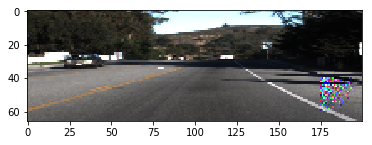

[-0.03490658]
[[0.01102882]]
[[0.03009764]]
[[0.63190466]]
[[1.724468]]


In [15]:
from skimage.color import yuv2rgb

# x = yuv2rgb(x_adv)
x = x_adv
plt.imshow(x)
plt.show()
print(y_test[i])
print(model.predict(x_test[i].reshape(1, 66, 200, 3)))
print(model.predict(x_adv.reshape(1, 66, 200, 3)))
print(model.predict(x_test[i].reshape(1, 66, 200, 3)) / np.p bghyi * 180)
print(model.predict(x_adv.reshape(1, 66, 200, 3)) / np.pi * 180)

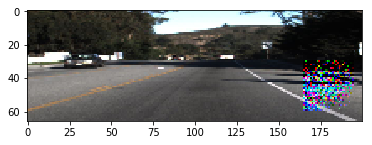

[-0.03490658]
[[0.01102882]]
[[0.10075956]]
[[0.9925935]]
[[9.06836]]


In [21]:
from skimage.color import yuv2rgb

# x = yuv2rgb(x_adv)
x = x_adv
plt.imshow(x)
plt.show()
print(y_test[i])
print(model.predict(x_test[i].reshape(1, 66, 200, 3)))
print(model.predict(x_adv.reshape(1, 66, 200, 3)))
print(model.predict(x_test[i].reshape(1, 66, 200, 3)) * 90)
print(model.predict(x_adv.reshape(1, 66, 200, 3)) * 90)

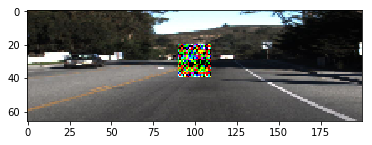

[-0.03490658]
[[0.01102882]]
[[0.36432517]]
[[0.63190466]]
[[20.874294]]


In [12]:
from skimage.color import yuv2rgb

# x = yuv2rgb(x_adv)
x = x_adv
plt.imshow(x)
plt.show()
print(y_test[i])
print(model.predict(x_test[i].reshape(1, 66, 200, 3)))
print(model.predict(x_adv.reshape(1, 66, 200, 3)))
print(model.predict(x_test[i].reshape(1, 66, 200, 3)) / np.pi * 180)
print(model.predict(x_adv.reshape(1, 66, 200, 3)) / np.pi * 180)

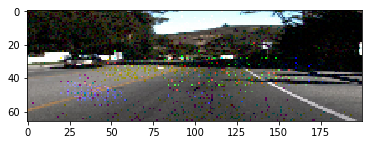

[-0.03490658]
[[0.01102885]]
[[0.93629795]]
[[0.63190675]]
[[53.64592]]


In [58]:
from skimage.color import yuv2rgb

# x = yuv2rgb(x_adv)
x = x_adv
plt.imshow(x)
plt.show()
print(y_test[i])
print(model.predict(x_test[i].reshape(1, 66, 200, 3)))
print(model.predict(x_adv.reshape(1, 66, 200, 3)))
print(model.predict(x_test[i].reshape(1, 66, 200, 3)) / np.pi * 180)
print(model.predict(x_adv.reshape(1, 66, 200, 3)) / np.pi * 180)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


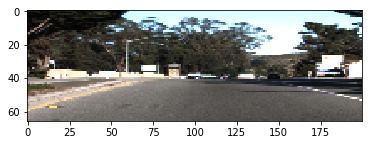

In [195]:
x = yuv2rgb(x_test[i])
plt.imshow(x)
plt.show()

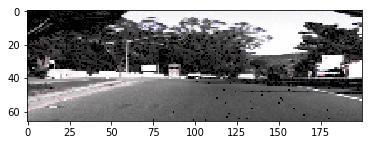

In [199]:
x = yuv2rgb(x_adv)
plt.imshow(np.clip(x, 0, 1))
plt.show()